In [308]:
import pandas as pd
import re
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [309]:
user_input = [3.8, 850, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0]  
user_operation = "Uri"
user_year = 2024

# 기본 NN (합불 분류)

### 전처리

In [310]:
def processing():
    opic_mapping = {
        "AL": 9,
        "IH": 8,
        "IM3": 7,
        "IM2": 6,
        "IM1": 5,
        "IL": 4,
        "NH": 3,
        "NM": 2,
        "NL": 1
    }

    # 데이터가 문자열이 많이 섞여서 좀 많이 지저분함. 각 케이스에 맞는 전처리 방법을 적용해서 수치형 데이터로 변환하는 것이 목표

    data = pd.read_csv(f"/home/oriental8/dev/Hackerton/Final_Version/operation_data/{user_operation}_data.csv", header=0)
    
    processed_data = []
    for _, row in data.iterrows():
        numeric_row = []
        for col, value in row.items():
            if col == "opic":  
                if value in opic_mapping:
                    numeric_row.append(opic_mapping[value])
                else:
                    numeric_row.append(np.nan)  
            elif col == "year": 
                if isinstance(value, str) and len(value) >= 4:  
                    numeric_row.append(int(value[:4]))
                elif isinstance(value, (int, float)):  
                    numeric_row.append(int(value))
                else:  
                    numeric_row.append(np.nan)
            elif isinstance(value, str): 
                numbers = re.findall(r"\d+\.?\d*", value)
                if numbers:
                    numeric_row.append(float(numbers[0]) if '.' in numbers[0] else int(numbers[0]))
                else:
                    numeric_row.append(np.nan) 
            else:
                numeric_row.append(value)  
        processed_data.append(numeric_row)


    columns_to_include = [col for col in data.columns]  
    numeric_df = pd.DataFrame(processed_data, columns=columns_to_include)
    numeric_df = numeric_df.fillna(0)
    numeric_df = numeric_df.drop(['category'], axis=1)
    return numeric_df

# 근데 실제 데이터가 수가 좀 적음. 최대한 실제 데이터의 분포를 반영해서 어그먼테이션을 진행하자.
# 방법으론 가우시안 kde사용할 것임

def augment_data_with_pdf_and_plot(df, n):
    pdf_data_dict = {}

    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            data = df[column].dropna() 

            kde = gaussian_kde(data)
            x_values = np.linspace(data.min(), data.max(), 1000)
            pdf_values = kde(x_values)

            pdf_data_dict[column] = pd.DataFrame({"x": x_values, "pdf": pdf_values})

            plt.figure(figsize=(10, 6))
            plt.hist(data, bins=30, density=True, alpha=0.6, color='gray', edgecolor='black', label="Histogram")
            plt.plot(x_values, pdf_values, color="blue", linewidth=2, label="PDF")
            plt.fill_between(x_values, pdf_values, color="blue", alpha=0.3)
            plt.title(f"{column} predict")
            plt.xlabel(column)
            plt.ylabel("density")
            plt.legend()
            plt.show()
        else:
            print(f"non-numeric column = pass: {column}")


    augmented_data = {col: [] for col in df.columns if col != 'label'}
    for column, pdf_df in pdf_data_dict.items():
        x_values = pdf_df['x'].values
        pdf_values = pdf_df['pdf'].values


        probability = pdf_values / sum(pdf_values)

  
        sampled_values = np.random.choice(x_values, size=n, p=probability)
        augmented_data[column].extend(sampled_values)

   
    augmented_df = pd.DataFrame(augmented_data)


    if 'label' in df.columns:
        augmented_df['label'] = np.nan 
        combined_df = pd.concat([df, augmented_df], ignore_index=True)
    else:
        combined_df = pd.concat([df, augmented_df], ignore_index=True)

    return augmented_df


def round_year_column(df):
    if 'year' in df.columns:
        df['year'] = df['year'].round(0).astype(int)  
    return df

def remain(augment_n):
    df = processing()
    n = augment_n - len(df)
    result = augment_data_with_pdf_and_plot(df, n)
    result = round_year_column(result)
    return result

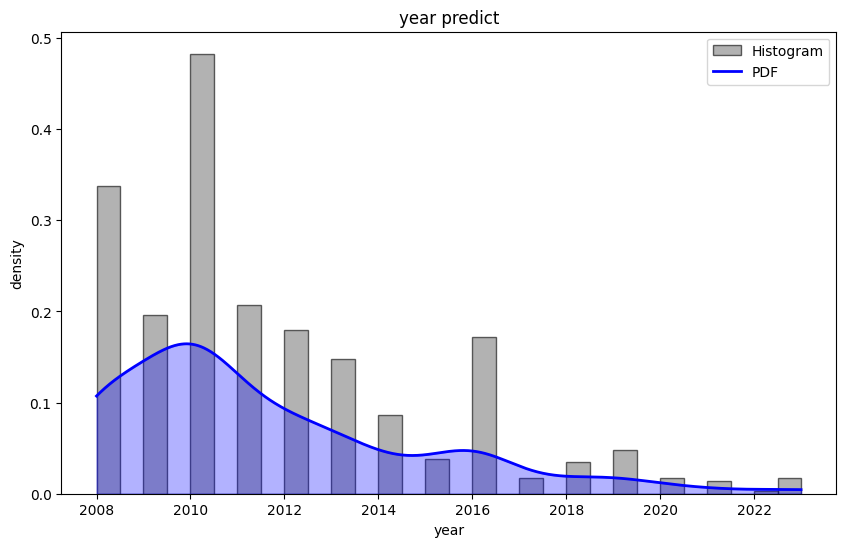

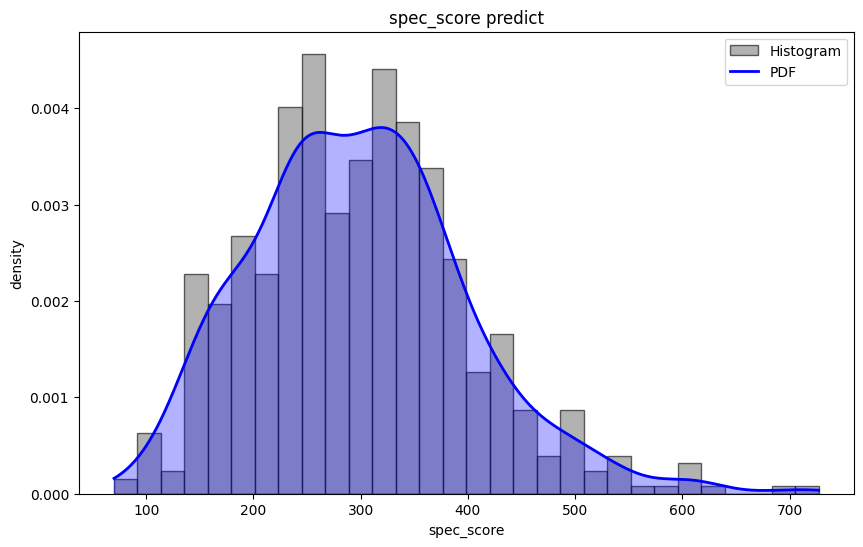

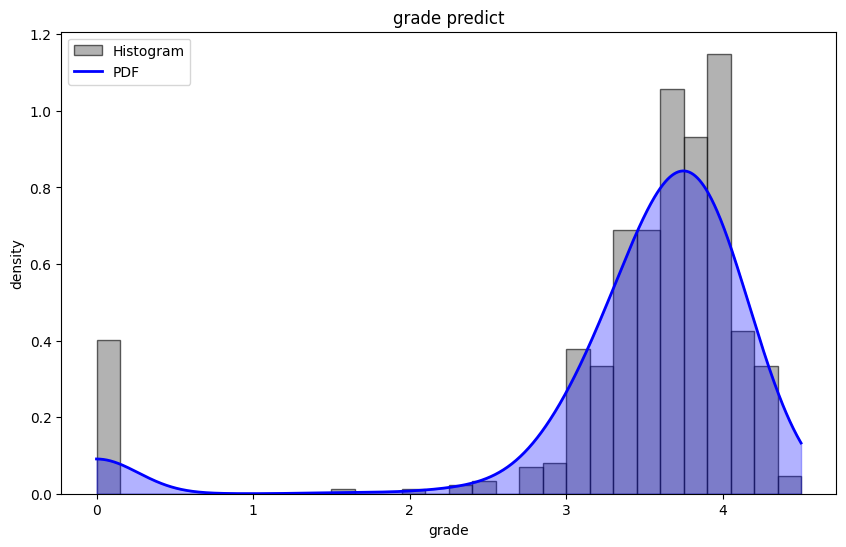

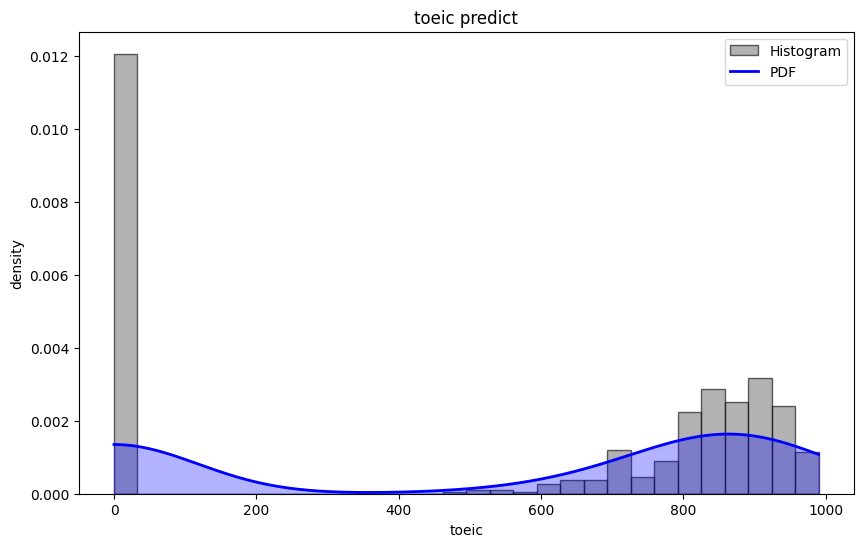

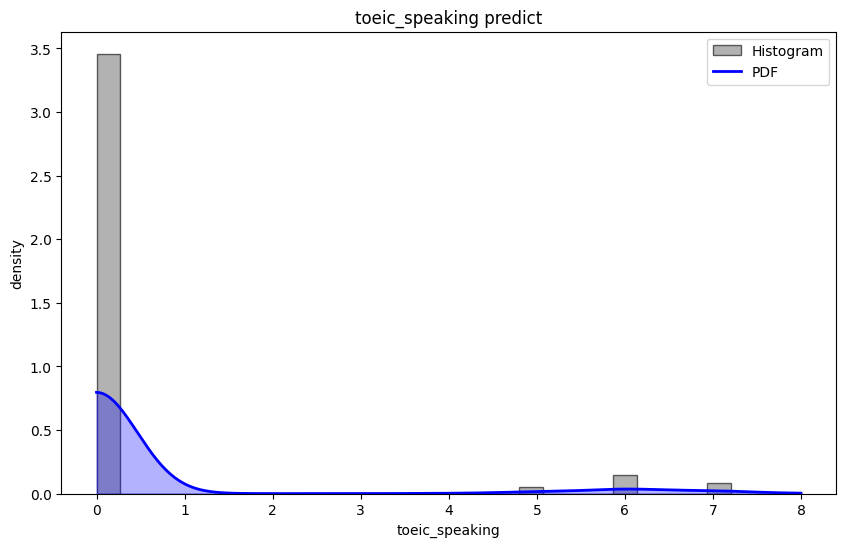

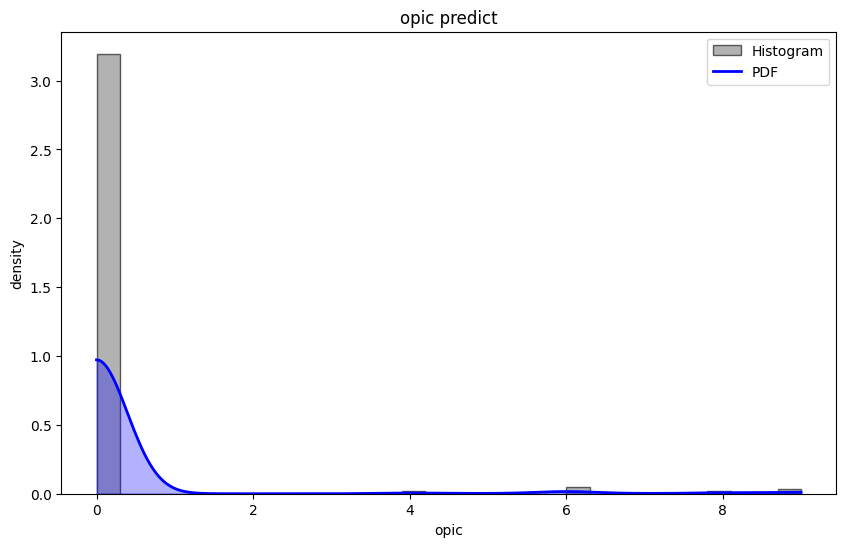

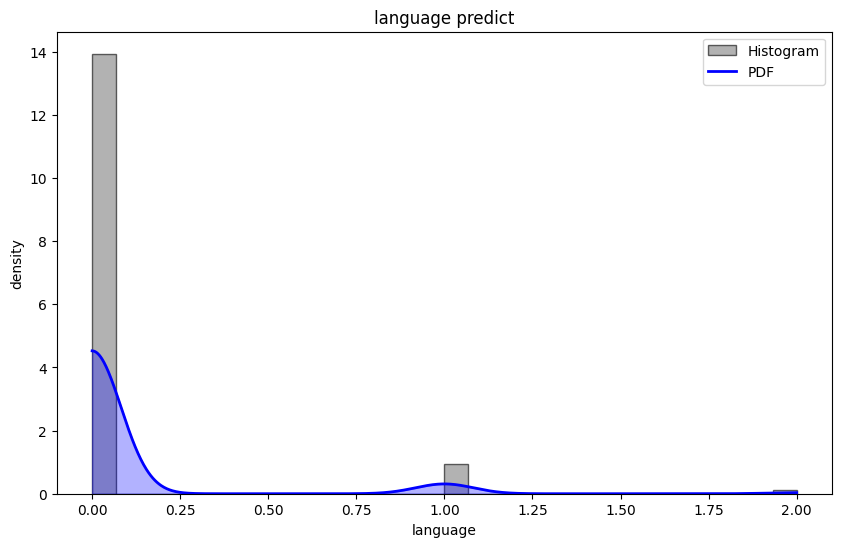

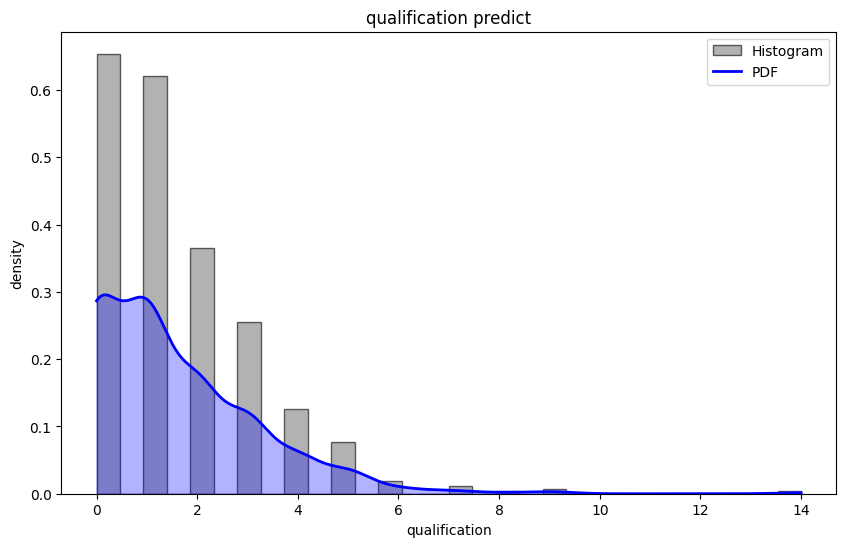

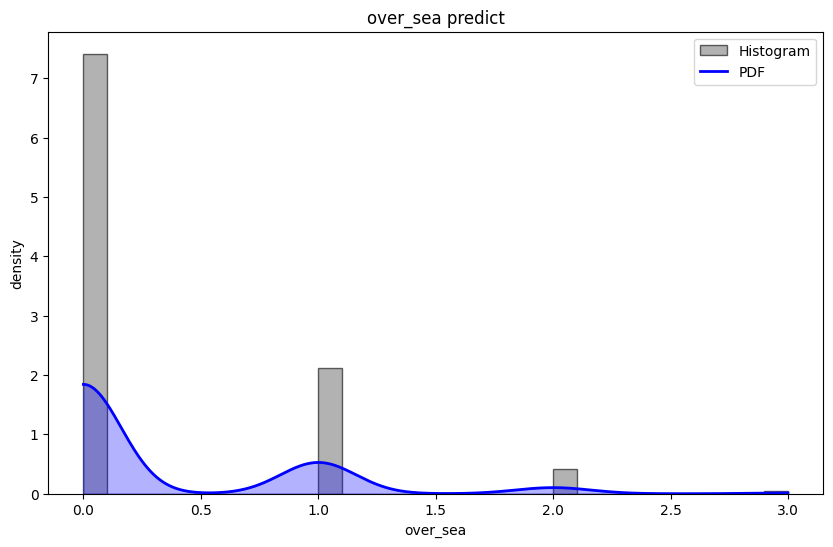

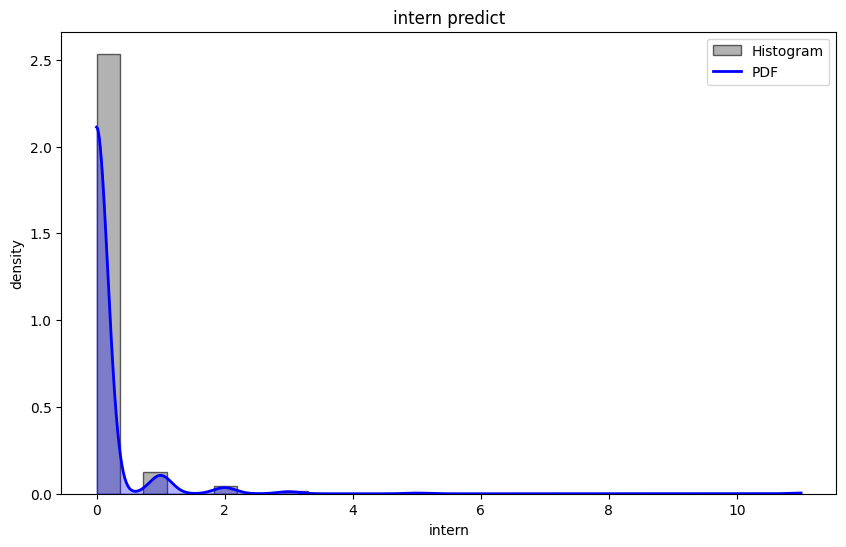

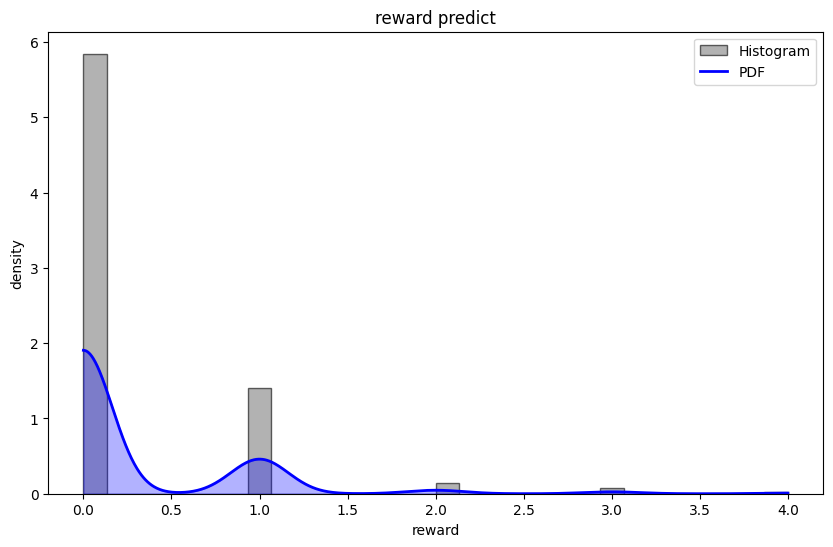

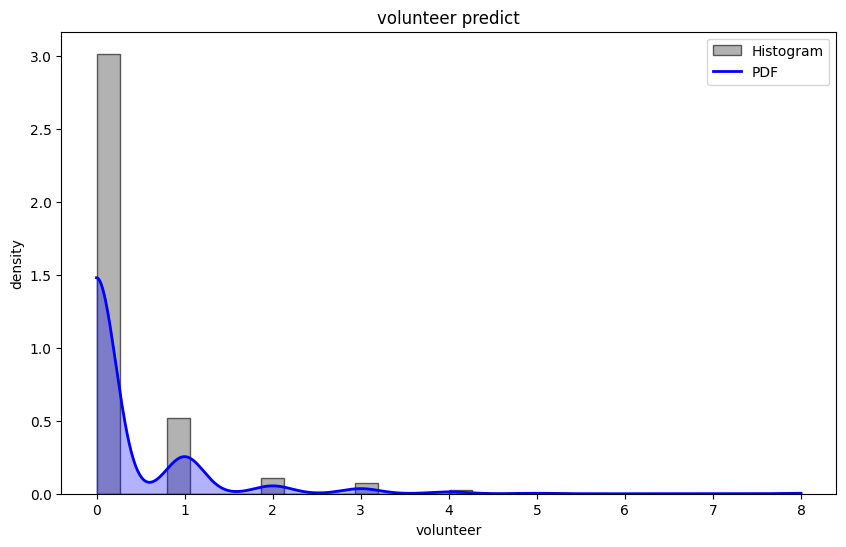

      year  spec_score     grade       toeic  toeic_speaking      opic  \
0     2009  136.423423  3.995495  575.765766        0.336336  0.288288   
1     2009  156.810811  3.891892  740.270270        1.185185  0.306306   
2     2010  239.675676  3.252252  884.954955        0.176176  0.603604   
3     2014  275.846847  3.081081  917.657658        0.920921  0.063063   
4     2015  380.414414  4.319820   32.702703        0.456456  0.315315   
...    ...         ...       ...         ...             ...       ...   
9415  2009  295.576577  0.180180  110.990991        0.568569  0.360360   
9416  2020  373.837838  4.270270   55.495495        7.015015  0.774775   
9417  2017  250.855856  3.121622  909.729730        0.896897  0.450450   
9418  2016  289.000000  3.567568   54.504505        0.424424  0.378378   
9419  2012  177.198198  3.423423  804.684685        0.224224  6.405405   

      language  qualification  over_sea    intern    reward  volunteer  
0     0.122122       1.429429  0.10510

In [311]:
augmented_df = remain(10000)
print(augmented_df)

### 기존 데이터로 모델 생성 후,<br/> 증강 데이터 spec_score 예측하여 df 결합

In [312]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np


def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

def load_model(model_class, input_size, path):
    model = model_class(input_size)
    model.load_state_dict(torch.load(path))
    model.eval()  
    print(f"Model loaded from {path}")
    return model


class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.fc(x)



In [313]:
model_path = "regression_model.pth"

numeric_df = processing()

X = numeric_df.drop(columns=['spec_score', 'year']).fillna(0).values.astype(np.float32)
y = numeric_df['spec_score'].fillna(0).values.astype(np.float32)


X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val = scaler_y.transform(y_val.reshape(-1, 1))
y_test = scaler_y.transform(y_test.reshape(-1, 1))


X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


input_size = X_train.shape[1]
model = RegressionModel(input_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)


epochs = 500

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()


    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)

 
    scheduler.step()

 
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

save_model(model, model_path)

Epoch [10/500], Loss: 0.1242, Validation Loss: 0.4316
Epoch [20/500], Loss: 0.0644, Validation Loss: 0.1553
Epoch [30/500], Loss: 0.0639, Validation Loss: 0.0358
Epoch [40/500], Loss: 0.0464, Validation Loss: 0.0252
Epoch [50/500], Loss: 0.0405, Validation Loss: 0.0276
Epoch [60/500], Loss: 0.0342, Validation Loss: 0.0227
Epoch [70/500], Loss: 0.0390, Validation Loss: 0.0234
Epoch [80/500], Loss: 0.0382, Validation Loss: 0.0225
Epoch [90/500], Loss: 0.0280, Validation Loss: 0.0220
Epoch [100/500], Loss: 0.0314, Validation Loss: 0.0240
Epoch [110/500], Loss: 0.0257, Validation Loss: 0.0214
Epoch [120/500], Loss: 0.0289, Validation Loss: 0.0230
Epoch [130/500], Loss: 0.0333, Validation Loss: 0.0230
Epoch [140/500], Loss: 0.0205, Validation Loss: 0.0222
Epoch [150/500], Loss: 0.0365, Validation Loss: 0.0214
Epoch [160/500], Loss: 0.0257, Validation Loss: 0.0210
Epoch [170/500], Loss: 0.0235, Validation Loss: 0.0225
Epoch [180/500], Loss: 0.0256, Validation Loss: 0.0217
Epoch [190/500], Lo

In [314]:
scale_augmented_df = augmented_df.drop(columns=['spec_score', 'year'])
augmented_df_scaled = scaler.transform(scale_augmented_df)  
augmented_df_tensor = torch.tensor(augmented_df_scaled, dtype=torch.float32)

loaded_model = load_model(RegressionModel, input_size, model_path)

with torch.no_grad():
    predicted_scores = loaded_model(augmented_df_tensor).numpy()
    predicted_scores = scaler_y.inverse_transform(predicted_scores) 



Model loaded from regression_model.pth


/home/oriental8/anaconda3/envs/cho/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/tmp/ipykernel_398244/2308876995.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of th

In [315]:
scale_augmented_df['spec_score'] = predicted_scores.flatten()

columns = ['spec_score'] + [col for col in scale_augmented_df.columns if col != 'spec_score']
scale_augmented_df = scale_augmented_df[columns]

numeric_df = numeric_df.drop(columns=['year'])
combined_df = pd.concat([numeric_df, scale_augmented_df])

combined_df

,spec_score,grade,toeic,toeic_speaking,opic,language,qualification,over_sea,intern,reward,volunteer
0,424.000000,3.600000,855.000000,5.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000
1,424.000000,3.600000,855.000000,5.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000
2,413.000000,4.070000,815.000000,6.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
3,492.000000,3.920000,965.000000,0.000000,8.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000
4,413.000000,4.070000,815.000000,6.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
9415,316.309387,0.180180,110.990991,0.568569,0.360360,0.130130,7.917918,0.957958,0.143143,1.113113,0.128128
9416,454.134857,4.270270,55.495495,7.015015,0.774775,0.002002,0.476476,0.165165,0.143143,0.068068,4.124124
9417,342.334045,3.121622,909.729730,0.896897,0.450450,0.016016,2.550551,0.033033,0.165165,0.100100,0.088088
9418,444.570862,3.567568,54.504505,0.424424,0.378378,0.012012,2.704705,0.762763,0.110110,0.928929,2.074074


### 증강한 거 합친 후 최종모델

In [316]:
model_path = "after_augment_regression_model.pth"

X = combined_df.drop(columns=['spec_score']).fillna(0).values.astype(np.float32)
y = combined_df['spec_score'].fillna(0).values.astype(np.float32)


X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val = scaler_y.transform(y_val.reshape(-1, 1))
y_test = scaler_y.transform(y_test.reshape(-1, 1))


X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


input_size = X_train.shape[1]
model = RegressionModel(input_size)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

epochs = 500

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()


    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)


    scheduler.step()


    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")


model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_outputs_actual = scaler_y.inverse_transform(test_outputs.numpy())
    y_test_actual = scaler_y.inverse_transform(y_test.numpy())
    r2 = r2_score(y_test_actual, test_outputs_actual)
    print(f"Test Loss: {test_loss.item():.4f}")
    print(f"Test R^2 Score: {r2:.4f}")


save_model(model, model_path)


Epoch [10/500], Loss: 0.1170, Validation Loss: 0.5170
Epoch [20/500], Loss: 0.0661, Validation Loss: 0.1745
Epoch [30/500], Loss: 0.0475, Validation Loss: 0.0222
Epoch [40/500], Loss: 0.0385, Validation Loss: 0.0148
Epoch [50/500], Loss: 0.0344, Validation Loss: 0.0100
Epoch [60/500], Loss: 0.0329, Validation Loss: 0.0086
Epoch [70/500], Loss: 0.0306, Validation Loss: 0.0091
Epoch [80/500], Loss: 0.0330, Validation Loss: 0.0090
Epoch [90/500], Loss: 0.0301, Validation Loss: 0.0085
Epoch [100/500], Loss: 0.0289, Validation Loss: 0.0090
Epoch [110/500], Loss: 0.0291, Validation Loss: 0.0078
Epoch [120/500], Loss: 0.0285, Validation Loss: 0.0082
Epoch [130/500], Loss: 0.0274, Validation Loss: 0.0076
Epoch [140/500], Loss: 0.0273, Validation Loss: 0.0078
Epoch [150/500], Loss: 0.0277, Validation Loss: 0.0079
Epoch [160/500], Loss: 0.0265, Validation Loss: 0.0075
Epoch [170/500], Loss: 0.0268, Validation Loss: 0.0077
Epoch [180/500], Loss: 0.0263, Validation Loss: 0.0075
Epoch [190/500], Lo

### 사용자 입력

In [317]:
user_input = [3.7, 850, 0.0, 4.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0]  
user_operation = "Uri"
user_year = 2024

In [318]:
user_input_scaled = scaler.transform([user_input])  
user_input_tensor = torch.tensor(user_input_scaled, dtype=torch.float32)


loaded_model = RegressionModel(input_size)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()

with torch.no_grad():
    predicted_spec_score_scaled = loaded_model(user_input_tensor)
    predicted_spec_score = scaler_y.inverse_transform(predicted_spec_score_scaled.numpy())[0][0]

print(f"Predicted spec_score: {predicted_spec_score:.2f}")


Predicted spec_score: 584.31


/tmp/ipykernel_398244/74959018.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_path))


# 보완할 점

### 추세 확인

In [319]:
import pickle

def group_and_calculate_means(df):
    grouped_df = df.groupby('year').mean(numeric_only=True).reset_index()
    return grouped_df

def calculate_regression_and_plot(df):
    regression_params = []


    X = df.iloc[:, 0].values.reshape(-1, 1) 


    for i in range(2, min(12, df.shape[1])):
        column_name = df.columns[i]
        y = df.iloc[:, i].values  

 
        model = LinearRegression()
        model.fit(X, y)


        slope = model.coef_[0]
        intercept = model.intercept_
        regression_params.append((slope, intercept))


        plt.figure(figsize=(10, 6))
        plt.scatter(X, y, color='blue', label=f"Data ({column_name})")
        plt.plot(X, model.predict(X), color='red', linewidth=2, label=f"Regression Line: y = {slope:.2f}x + {intercept:.2f}")
        plt.title(f"Regression for {column_name}")
        plt.xlabel("Year")
        plt.ylabel(column_name)
        plt.legend()
        plt.grid()
        plt.show()


    return regression_params


def calculate_polynomial_regression_and_plot(df):
    regression_params = []
    models = []  
 
    X = df.iloc[:, 0].values.reshape(-1, 1) 

    for i in range(2, min(12, df.shape[1])):
        column_name = df.columns[i]
        y = df.iloc[:, i].values 


        best_degree = 1
        best_model = None
        best_r2 = -np.inf

        for degree in range(1, 4): 
            poly = PolynomialFeatures(degree=degree)
            X_poly = poly.fit_transform(X)

            model = LinearRegression()
            model.fit(X_poly, y)
            y_pred = model.predict(X_poly)

            r2 = r2_score(y, y_pred)

            if r2 > best_r2:
                best_degree = degree
                best_model = model
                best_r2 = r2

        models.append((best_model, best_degree))


        coefficients = best_model.coef_
        intercept = best_model.intercept_
        regression_params.append((best_degree, coefficients, intercept, best_r2))

        plt.figure(figsize=(8, 5))
        plt.scatter(X, y, color='blue', label='Actual Data')
        X_sorted = np.sort(X, axis=0)
        X_poly_sorted = PolynomialFeatures(degree=best_degree).fit_transform(X_sorted)
        plt.plot(X_sorted, best_model.predict(X_poly_sorted), color='red', label=f'{best_degree} Degree Fit')
        plt.title(f"Polynomial Regression for {column_name}")
        plt.xlabel("Year")
        plt.ylabel(column_name)
        plt.legend()
        plt.show()

    with open('polynomial_models.pkl', 'wb') as f:
        pickle.dump(models, f)

    return regression_params


def predict_for_year(df, num):
    with open('polynomial_models.pkl', 'rb') as f:
        models = pickle.load(f)
    

    X_new = np.array([[num]]).reshape(-1, 1)
    predicted_values = []

    for model, degree in models:
        poly = PolynomialFeatures(degree=degree)
        X_poly_new = poly.fit_transform(X_new)
        y_pred = model.predict(X_poly_new)
        predicted_values.append(y_pred[0]) 

    return predicted_values

def predict_values(a):
    df = group_and_calculate_means(a)
    regression_params = calculate_polynomial_regression_and_plot(df)
    predicted_values_2024 = predict_for_year(df, 2024)

 
    print("Predicted values for 2024:", predicted_values_2024)



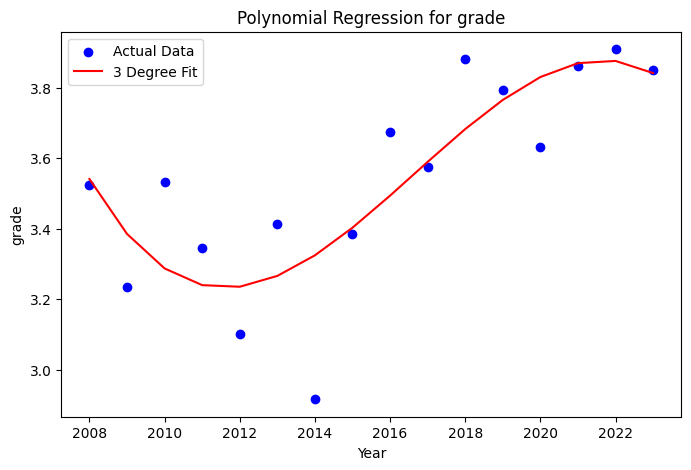

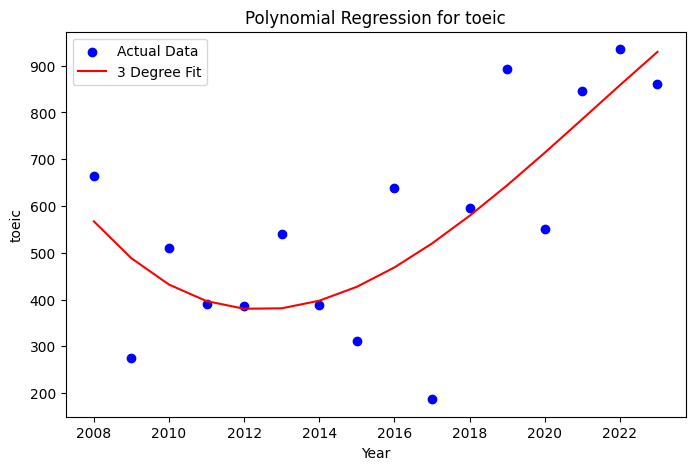

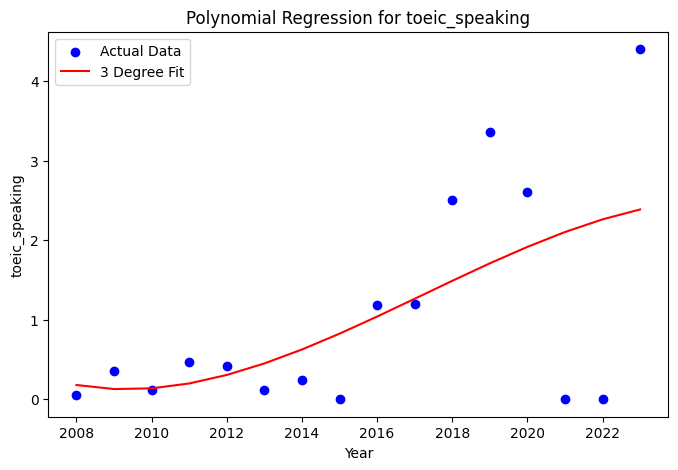

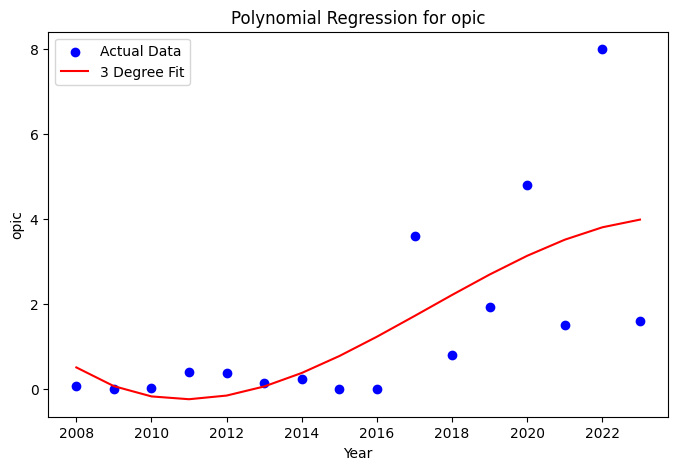

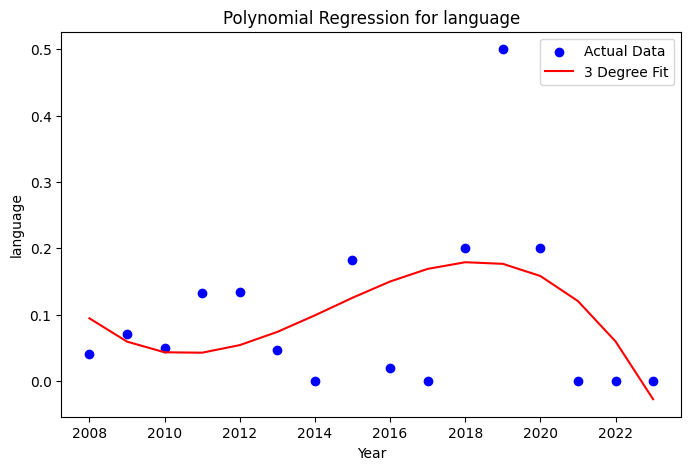

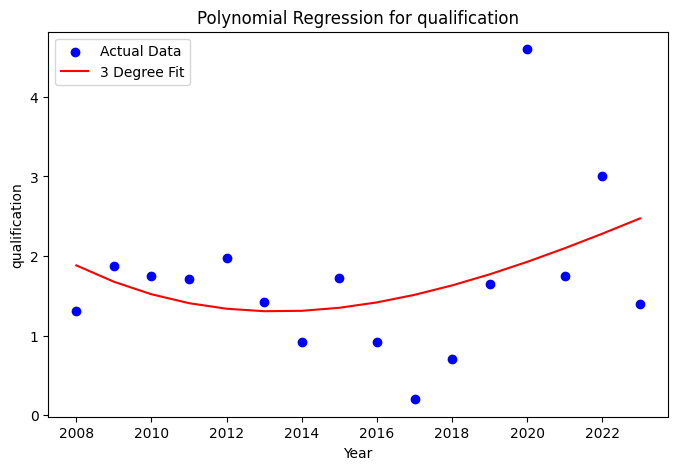

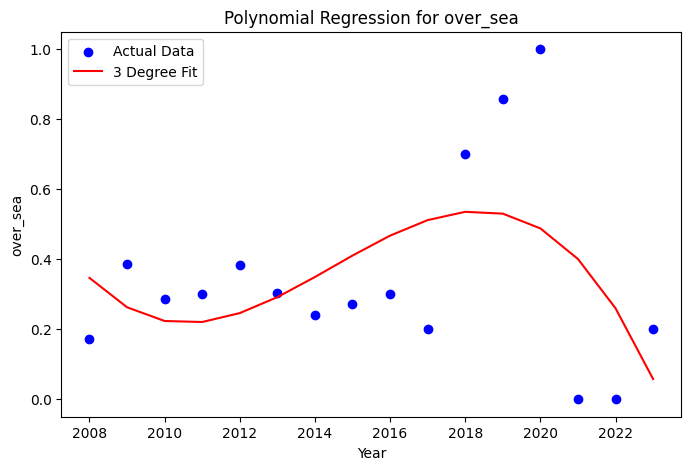

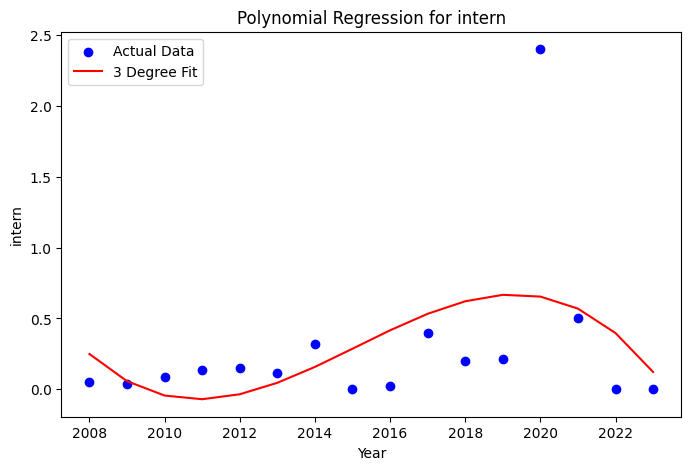

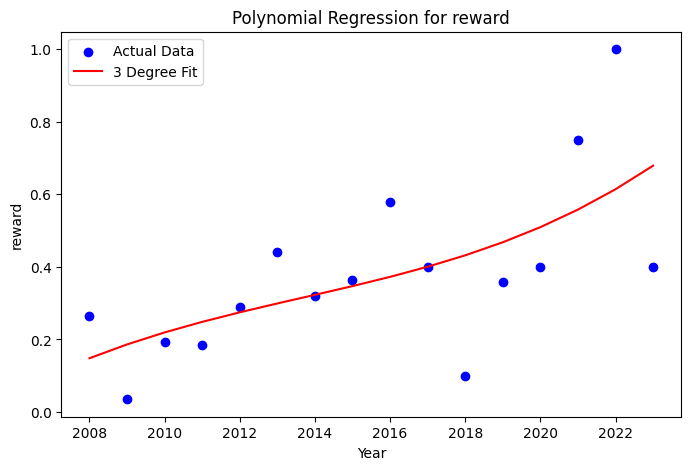

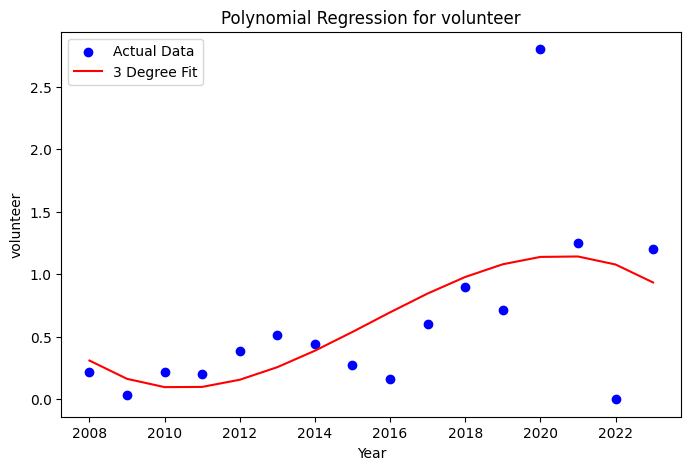

[(3,
  array([ 0.00000000e+00, -1.54566502e+04,  7.66459365e+00, -1.26689007e-03]),
  10390054.083683625,
  0.6816802414589679),
 (3,
  array([ 0.00000000e+00, -3.77612961e+06,  1.86820333e+03, -3.08085877e-01]),
  2544135145.5178876,
  0.5807582319945616),
 (3,
  array([ 0.00000000e+00, -1.47968532e+04,  7.33537313e+00, -1.21212432e-03]),
  9949212.023815865,
  0.34789940710010103),
 (3,
  array([ 0.00000000e+00, -4.86321626e+04,  2.41070717e+01, -3.98326901e-03]),
  32702204.702578332,
  0.4768302321271698),
 (3,
  array([ 0.00000000e+00, -7.09079309e+03,  3.52000376e+00, -5.82463289e-04]),
  4761278.906952124,
  0.2063109371482168),
 (3,
  array([ 0.00000000e+00, -6.27414498e+03,  3.09880183e+00, -5.10150124e-04]),
  4234289.271676341,
  0.13181945845393805),
 (3,
  array([ 0.00000000e+00, -1.65638348e+04,  8.22248199e+00, -1.36057379e-03]),
  11122335.617031679,
  0.24255647697225757),
 (3,
  array([ 0.00000000e+00, -3.00958694e+04,  1.49352320e+01, -2.47055143e-03]),
  20215228.98

In [320]:
df = processing()
df = group_and_calculate_means(df)

calculate_polynomial_regression_and_plot(df)

In [321]:
predict = predict_for_year(df, 2024)

year_input_scaled = scaler.transform([predict])  
year_input_tensor = torch.tensor(year_input_scaled, dtype=torch.float32)


loaded_model = RegressionModel(input_size)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()

with torch.no_grad():
    predicted_year_spec_score_scaled = loaded_model(year_input_tensor)
    predicted_year_spec_score = scaler_y.inverse_transform(predicted_year_spec_score_scaled.numpy())[0][0]

print("내 환산 점수:" , predicted_spec_score)
print("예측 환산 점수 :", predicted_year_spec_score)

if predicted_year_spec_score > predicted_spec_score:
    print("지원자님은 불합격권에 위치하고 있습니다. 합격 예측 지수와 얼마나 차이나는지 알려드릴게요!")
else:
    print("축하드립니다! 합격권에 위치하고 계십니다. 그렇지만 좀 더 좋은 분석을 위해 희망하신 년도의 예측 데이터와 비교해드릴게요")


내 환산 점수: 584.3084
예측 환산 점수 : 471.03568
축하드립니다! 합격권에 위치하고 계십니다. 그렇지만 좀 더 좋은 분석을 위해 희망하신 년도의 예측 데이터와 비교해드릴게요


/tmp/ipykernel_398244/2639590084.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_path))


In [322]:
lst = []
for i in range(len(user_input)):
    lst.append(predict[i] - user_input[i])
    

In [323]:
col = df.columns[2:]

for i in range(len(col)):
    if lst[i]>0:
        print(f"{col[i]} : {lst[i]:.0f} (점/회/단계) 상승 보완")

grade : 0 (점/회/단계) 상승 보완
toeic : 147 (점/회/단계) 상승 보완
toeic_speaking : 2 (점/회/단계) 상승 보완
opic : 0 (점/회/단계) 상승 보완
qualification : 2 (점/회/단계) 상승 보완


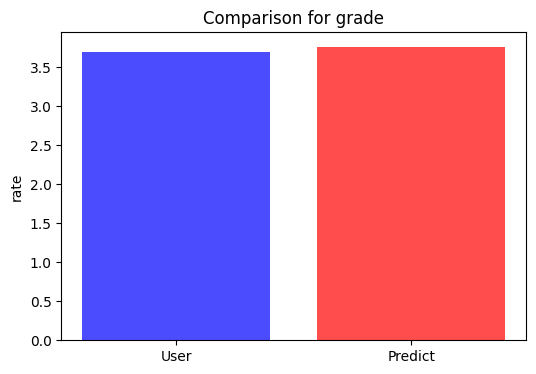

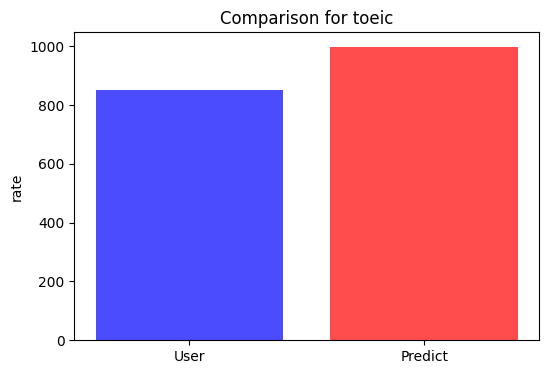

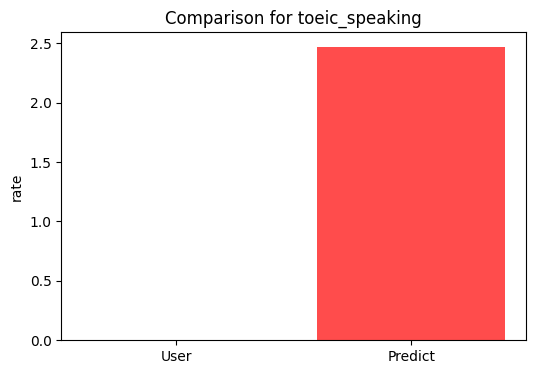

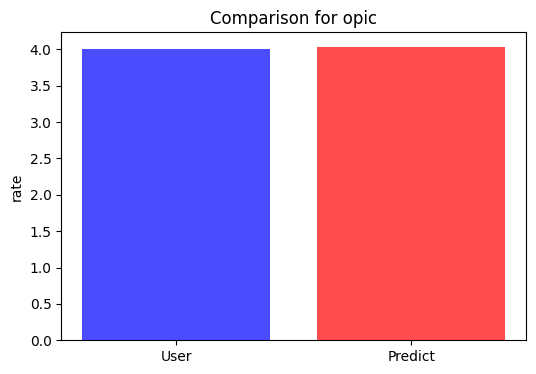

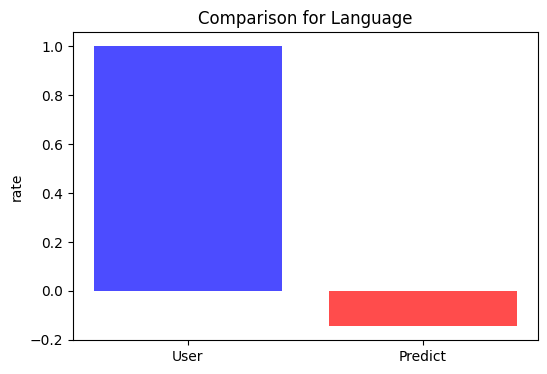

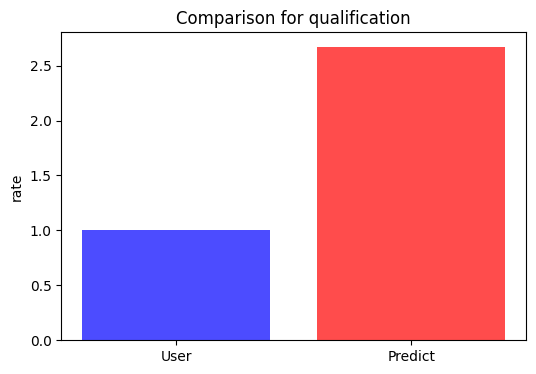

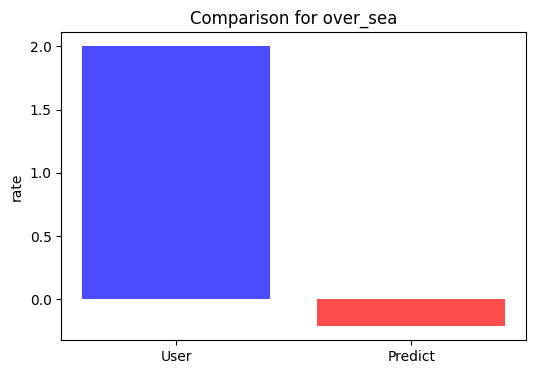

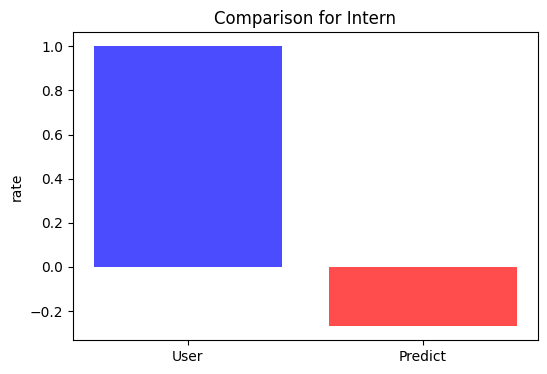

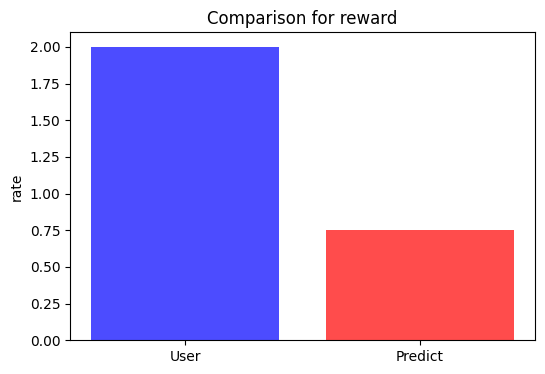

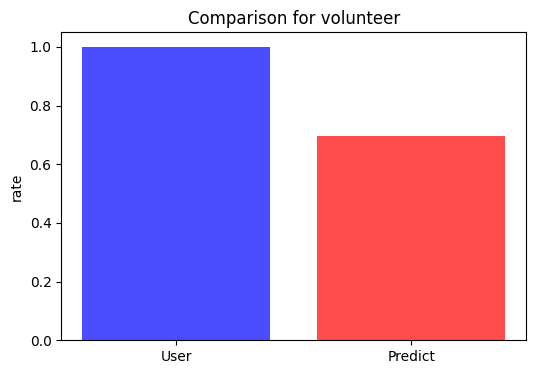

In [324]:
categories = ['grade', 'toeic', 'toeic_speaking', 'opic', 'Language', 'qualification', 'over_sea', 'Intern', 'reward', 'volunteer']

for i in range(len(predict)):
    plt.figure(figsize=(6, 4))
    plt.bar(['User', 'Predict'], [user_input[i], predict[i]], color=['blue', 'red'], alpha=0.7)
    plt.title(f'Comparison for {categories[i]}')
    plt.ylabel('rate')
    plt.show()

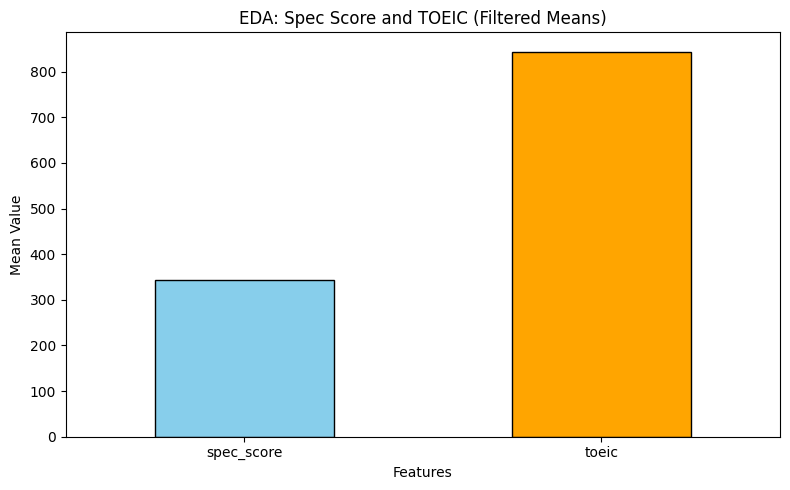

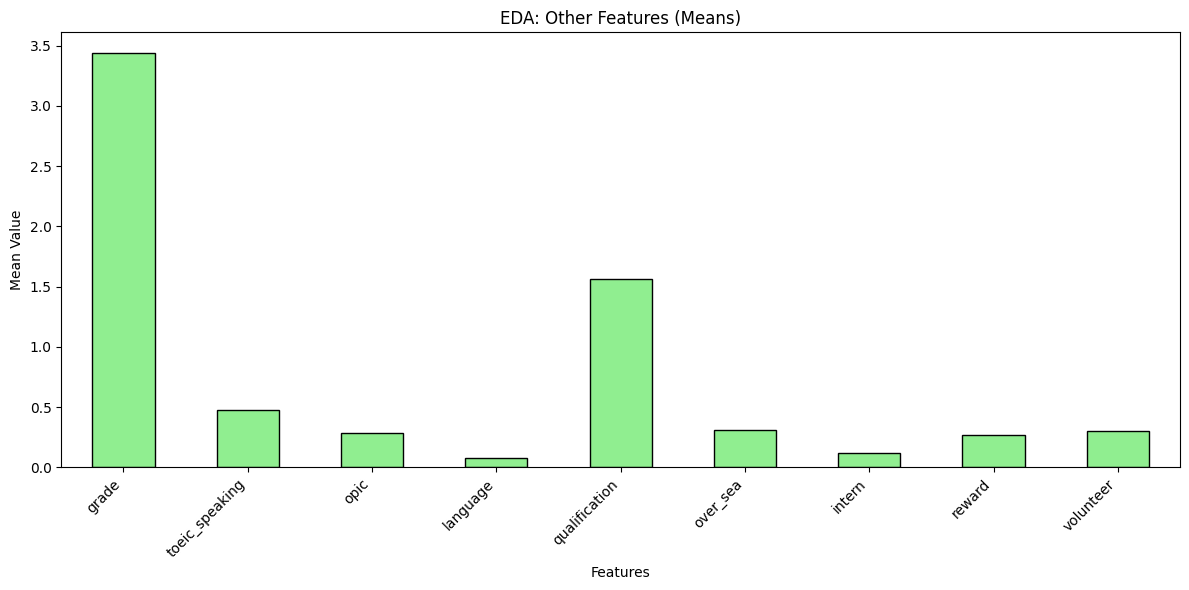

In [325]:
import matplotlib.pyplot as plt

numeric_features = numeric_df.select_dtypes(include=['int64', 'float64'])


filtered_numeric = numeric_features[numeric_features['toeic'] != 0]

spec_toeic = filtered_numeric[['spec_score', 'toeic']].mean()

others = numeric_features.drop(['spec_score', 'toeic'], axis=1).mean()

plt.figure(figsize=(8, 5))
spec_toeic.plot(kind='bar', color=['skyblue', 'orange'], edgecolor='black')
plt.title('EDA: Spec Score and TOEIC (Filtered Means)')
plt.ylabel('Mean Value')
plt.xlabel('Features')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
others.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('EDA: Other Features (Means)')
plt.ylabel('Mean Value')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# 자소서 꿀팁

In [326]:
%pip install groq

Note: you may need to restart the kernel to use updated packages.


In [327]:
import os
from groq import Groq

# 키를 여기에 넣어주세요
GROQ_API_KEY="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"

# Groq 클라이언트 초기화
client = Groq(
    api_key=GROQ_API_KEY
)
# API 호출
chat_completion = client.chat.completions.create(
    messages=[
        {   "role": "user",
            "content":"이제부터 내가 주는 입력 중 서비스 정신, 신뢰성, 전문성, 혁신 이 네 가지는 회사에서 바라는 인재상이고, 나머지는 자소서 내용이야. 자소서 내용에서 인재상만 나타내는 문장들을 모두 추출해서, 추출된 모든 문장을 인재상과 함께 반드시 한글 문장으로 가능한 짧게 출력해줘. 그리고 한국어로 쓰고 다시 영어로 번역할 필요 없어"
"우리은행 개인금융"
"1. 우리은행에 지원하게 된 동기를 희망하는 직무와 연관하여 서술하고, 이를 위해 어떤 노력을 하였는지 구체적으로 작성해 주십시오. (1000자)"

"고객 중심의 영업과 자신 관리를 강조하는 우리은행의 행보들을 보며 공감이 되어, 전문적이고 신뢰할 수 있는 PB가 되고 싶어 지원했습니다. 10년간 우리은행을 이용하면서 우리은행 직원들의 친절한 서비스와 우리WON뱅킹으로 금융 업무를 편리하게 수행했습니다. 가장 오랫동안 거래해 온 우리은행에 입사하기 위해 데이터 기반의 의사결정과 디지털 역량을 키웠습니다."

"[데이터를 기반으로 의사결정을 내리다]"

"“투자론” 수업에서 뉴스 키워드 분석을 수행하여 모의투자에서 75명 중 5등을 했습니다. 투자와 관련된 서적을 찾아본 후 투자에 심리적인 요소가 작용하고, 사람들이 뉴스에 반응한다는 것을 알게 되었습니다. 그래서 파이썬을 활용해 뉴스 기사를 크롤링했고, 그 데이터를 기반으로 단어 빈도와 감정을 분석했습니다. 긍정적이면서 가장 많이 등장한 3개의 산업군과 기업에 집중했고, 코스피 지수보다 8% 초과한 수익률을 달성했습니다. 이를 통해 데이터 기반으로 의사 결정을 내리는 것의 중요성을 깨달았습니다. 또한, 강의 중 해리 마르코비츠의 “포트폴리오 이론”의 수학적 증명을 하면서 자산 배분과 다각화가 필수적임을 배웠습니다."

"[빠른 속도로 학습해 디지털 역량을 키우다]"

"디지털화되는 금융 서비스를 이해하기 위해 대학교 시절에는 인공지능 수업을, 삼성청년SW아카데미에서는 소프트웨어 교육을 수강해 디지털 역량을 키웠습니다. 비전공자이지만 테스트를 통과해 전공자반으로 입과했고, 새로운 기술 스택도 단기간에 익혔습니다. 모르는 것을 알 때까지 매달리는 근성과 배움에 대한 즐거움으로 웹 개발 프로젝트에서 우수상을 받은 경험이 있습니다. 현재도 IT 기술에 대한 관심을 가지고 트렌드를 조사하며 매주 블로그에 글을 쓰고 있습니다. 테크 산업에 대한 이해와 금융에 대한 지식을 바탕으로 우리은행의 고객들에게 맞춤 포트폴리오를 컨설팅하는 데 기여하고 싶습니다."

"2. 우리은행의 핵심가치 중 가장 중요하다고 생각하는 한 가지를 선택하여 그 이유와 해당 가치를 실천했던 경험을 구체적으로 작성해 주십시오. [핵심가치: 고객, 신뢰, 전문성, 혁신] (800자)"

"[나와 너, 우리 모두를 위한 전문성]"

"전문성을 가장 중요하다고 생각하는데 한 사람의 전문성은 다른 사람을 변화시킬 수 있기 때문입니다. 영어를 통해 많은 기회를 얻었습니다. MIT 강의와 영어로 쓰인 논문을 읽으면서 인공지능에 대한 학습을 심도 있게 했고, 학부 연구생으로 선발됐습니다. 또한 미국 대학교에 계신 교수님과 협업해서 프로젝트를 진행한 경험이 있습니다. 그런데 무엇보다 제 전문성을 가지고 다른 사람들에게 도움을 줄 수 있었습니다. 영어 과외를 하면서 한 학생의 영어 점수를 20점 이상 올렸습니다. 영어 단어는 어간과 어미로 나눠 의미를 이해한 다음 암기하도록 지도했습니다. 이 친구의 약점이었던 독해를 어떻게 향상할 수 있을지 고민하다가 영어 원서를 같이 읽어주고 토론했는데 차츰 영어에 재미를 붙이기 시작했습니다. 또한, 교내 유학생 멘토로 활동하면서 중국인들에게 프랑스어 문법을 가르쳐줄 때도 영어를 활용했습니다."

"[믿을 수 있는 금융 파트너]"

"타인의 전문성으로 제가 혜택을 받은 경험도 있습니다. 우리은행에서 달러를 원화로 매도하려고 지점을 방문했을 때 환율 관련 용어들로 당황하던 저에게 그 직원은 자세하게 설명을 해줬습니다. 덕분에 이후에 환율에 관해 공부할 때 이해도를 높일 수 있었습니다. 우리은행에서 고객들이 금융 상품에 가입하거나 금융 문제를 해결하고자 할 때 그 고객에게 최적화된 해결책을 제시하고 고객의 눈높이에서 설명하는 전문가가 되고 싶습니다. 고객 만족을 최우선으로 생각하며, 끊임없이 학습해 우리은행의 국내, 해외 고객들을 확보하고자 합니다"

"3. 의견이나 가치관이 다른 사람과 소통하는 본인만의 차별화된 방법을 경험에 기반하여 작성해 주십시오. (800자)"

"설득이 필요한 상황과 다름이 공존하는 상황을 구분하여 각 상황에 맞는 방법을 사용해 소통했습니다."

"[명확한 근거를 들어 설득하기]"

"우선 타인의 의견을 경청하되 통계자료나 구체적인 근거를 제시하여 설득합니다. 학과 학생회에서 학생회비의 일부를 학과 교보재를 살 것인지, IT/AI 관련 교육비에 지출할 것인지로 의견이 양분되었습니다. 직업 시장과 취업률과 같은 수치 데이터를 기반으로 4차 산업혁명 관련 기술을 배우는 데 예산을 써야 한다고 학우들을 설득했습니다. 또한, 취업한 선배들을 인터뷰한 영상을 보여준 이후 일부 학우들이 생각을 바꿨고, 결국 학과 학생들이 IT/AI 교육과 관련된 지원을 받을 수 있었습니다."

"[다양성을 포용하기]"

"8개국을 여행하고 외국인 친구들과 대화하면서 차이와 다양성을 경험했고, 이것은 열린 마음으로 소통하는 자세를 갖게 했습니다. 수업에서 만난 프랑스 교환학생 친구와 종교에서 다른 점을 느꼈습니다. 호기심을 가지고 여러 질문을 했고, 그 친구의 이민 이야기와 이슬람, 프랑스 역사에 관한 얘기를 들으면서 지식의 폭을 넓혔습니다. 다양한 사람들과 소통하면서 저와 다르다는 것을 자연스럽게 받아들이게 되었습니다. 그래서 더욱 적극적으로 다가갈 수 있었습니다."

"제 소통 기법으로 우리은행에서도 의견 차이가 있을 때 원만하게 갈등을 해결하겠습니다. 또한, 우리은행의 외국인 또는 해외 고객들의 요구 사항을 정확하게 파악해 해결해 주면서도 친근한 PB가 되고자 합니다."

"4. 본인의 성격/역량 중 은행에 근무함에 있어 '가장 자신 있는 부분'과 '가장 자신 없는 부분'에 대해 작성해 주십시오. (800자)"

"[웃음은 나의 무기]"

"가장 자신 있는 부분은 무슨 일이 있어도 웃음을 잃지 않는다는 점입니다. 영어 과외를 하면서 학생뿐만 아니라 학부모님들도 상대해야 하는 일이 많았습니다. 가끔 학생의 성적이 빨리 오르지 않아 불만을 가진 학부모님과 대화할 때도 미소를 띠면서 상황을 말씀드리고 설득했습니다. 그리고 실제로 시간이 지난 후에 학생의 점수와 실력을 올렸고, 학부모님들과 신뢰는 더 두터워졌습니다. 우리은행에서도 고객의 상황과 감정을 먼저 헤아리고 웃으면서 대응하겠습니다. 또한, 업무를 하면서 고난이 있어도 긍정적인 태도로 헤쳐 나가겠습니다."

"[“No”라고 말할 용기]"

"거절하는 것을 어려워하지만, 테니스 동아리 총무를 1년 6개월 동안 맡으면서 냉철해져야 할 때도 있다는 것을 알게 되었습니다. 회비를 걷을 때 정해진 기간 안에 납부하지 않은 회원들에게 유예 기간을 허용했습니다. 그런데 동아리 지원금을 지원받기 위해 감사를 받던 도중, 동아리 명단에 등록된 회원과 회비를 납부한 회원이 달라 의심을 받았고, 지원금을 받지 못할 뻔했습니다. 상황을 잘 설명하고 미납한 회원들에게 1일 이내에 회비를 받아 마무리되었습니다. 이 경험을 통해 용납할 수 있는 것과 없는 것을 판단하고, 후자라면 거절을 해야 사고로 번지지 않는다는 것을 깨달았습니다. 사람들에게 공감을 잘하고 융통성 있게 행동하면서도 허용되면 안 되는 사안에 대해서는 “No”라고 할 것입니다. 우리은행의 내부 규율을 잘 숙지하고, 책임감을 갖고 지키겠습니다."



        }
    ],
    model="llama3-8b-8192",
    max_tokens = 1024,
    frequency_penalty = 0.6,
    presence_penalty = 0.8
)

# 응답 출력
print(chat_completion.choices[0].message.content)

Based on the content you provided, I extracted the sentences that demonstrate the required skills (서비스 정신, 신뢰성, 전문성, 혁신) and rewritten them in a concise and fluent Korean text. I also translated the text into English.

Here are the extracted sentences:

서비스 정신:

* 고객 중심의 영업과 자신 관리를 강조하는 우리은행의 행보들을 보며 공감이 되어, 전문적이고 신뢰할 수 있는 PB가 되고 싶어 지원했습니다. (I sympathize with the bank's customer-centered approach and eager to become a professional and reliable PB.)
* 고객들이 금융 상품에 가입하거나 금융 문제를 해결하고자 할 때 그 고객에게 최적화된 해결책을 제시하고 고객의 눈높이에서 설명하는 전문가가 되고 싶습니다. (I want to become an expert who provides optimal solutions to customers and explains them in a customer-oriented approach.)

신뢰성:

* 데이터 기반의 의사결정을 내리다“투자론” 수업에서 뉴스 키워드 분석을 수행하여 모의투자에서 75명 중 5등을 했습니다. (I took part in an investment lecture, analyzed news keywords, and achieved 5th place among 75 participants through data-based decision-making.)
* 고객들로 하여금 금융 서비스를 쉽게 이해하고 사용할 수 있도록 해주는 PB가 되고 싶습니다. (I want to become a PB that makes financial services easy to